In [1]:
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
from sklearn.model_selection import train_test_split

plt.rcParams['figure.figsize'] = 25, 10

In [3]:
full = pd.read_csv('data/cardio_train.csv', sep=';')
full.set_index('id', inplace=True)


## Pre procesado de datos
Dentro de la area del pre-procesado de datos del Trabajo Practico vamos a eliminar todos aquellos valores que no condicen con una situación real de un paciente. **Las variables dentro de nuestro Dataset que contienen estos valores que no reflejan la realidad son: Presión arterial (ambas), y peso.**


In [4]:
#Eliminamos todos aquellos valores que no se encuentren en el rango (40,250)
full =full[full['ap_hi'] <= 250]
full =full[full['ap_hi'] >= 40]

#Eliminamos todos aquellos valores que no se encuentren en el rango (0,200)
full =full[full['ap_lo'] <= 200]
full =full[full['ap_lo'] >= 0]

#Eliminamos todos aquellos valores que se encuentren por debajo de 60 kilogramos
full =full[full['height'] >= 60]

## Feature Engineering
Dentro de este apartado, vamos a buscar mejorar la capacidad de expresar el problema, a traves de Feature Ingineering. A partir de la técnica denominada **binning/redondeo de números** vamos a convertir la **edad del paciente** de días a años y el **la altura del paciente** de centimetros a metros.

In [5]:
# Transformamos edad de dias a años
full['age'] = full['age']/365

# Transformamos la altura de centimetros a metros
full['height'] = full['height']/100

Otra tecnica que vamos a utilizar es generar una nueva variable: A partir de el **peso** y la **altura** generaremos una nueva variable que denominaremos Masa corporal. 

In [6]:
# Generamos la variable masa corporal
full['body_mass'] = full['weight']/(full['height'] * full['height'])

# Mostramos el Dataset modificado
full.head()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,body_mass
id,,,,,,,,,,,,,
0,50.391781,2,1.68,62.0,110,80,1,1,0,0,1,0,21.967120
1,55.419178,1,1.56,85.0,140,90,3,1,0,0,1,1,34.927679
2,51.663014,1,1.65,64.0,130,70,3,1,0,0,0,1,23.507805
3,48.282192,2,1.69,82.0,150,100,1,1,0,0,1,1,28.710479
4,47.873973,1,1.56,56.0,100,60,1,1,0,0,0,0,23.011177


In [7]:
full.dtypes

age            float64
gender           int64
height         float64
weight         float64
ap_hi            int64
ap_lo            int64
cholesterol      int64
gluc             int64
smoke            int64
alco             int64
active           int64
cardio           int64
body_mass      float64
dtype: object

In [8]:
# 60% train, 20% test, 20% validation
train, not_train = train_test_split(full, test_size=0.4)
validation, test = train_test_split(not_train, test_size=0.5)

In [9]:
def evaluate_model(model, extract_inputs_function, extract_outputs_function, include_validation=False):
    sets = [('train', train), ('test', test)]
    if include_validation:
        sets.append(('validation', validation))
        
    for set_name, set_data in sets:
        inputs = extract_inputs_function(set_data)
        outputs = extract_outputs_function(set_data)
        predictions = model.predict(inputs) 
        
        print(set_name, '#' * 80)
        
        # print metrics
        
        print('Accuracy:', accuracy_score(outputs, predictions))
        #print('Precision:', precision_score(outputs, predictions))
        print('Recall:', recall_score(outputs, predictions))
        print()
        
        # plot confussion matrix
        
        plt.figure(figsize=(3,4))
        
        plt.xticks([0, 1], ['has_disease', 'hasnt_disease'], rotation=45)
        plt.yticks([0, 1], ['has_disease', 'hasnt_disease'])
        plt.xlabel('Predicted class')
        plt.ylabel('True class')

        plt.title(set_name)

        plt.imshow(
            confusion_matrix(outputs, predictions), 
            cmap=plt.cm.Blues, 
            interpolation='nearest',
        )

        plt.show()

## Métricas
En nuestro caso contamos con el set de datos perfectamente balanceado (50-50 % antes del pre-procesado y 49-51 % luego de la limpieza), por lo que vamos a utilizar como métrica Accuracy.
Esta métrica es muy buena para la clacificación cuando el dataset está bien balanceado, evitando problemas como por 
ejemplo que prediga siempre la misma clase.

Esta métrica nos va a indicar el porcentaje de aciertos que tuvimos.

También vamos a utilizar la metrica Recall ya que nos interesa, de los casos con problemas cardíacos, encontrar la mayor cantidad posible.


## First model: logistic regression

In [10]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

In [11]:
# final input columns, in the order we want to use them
LR_INPUT_COLUMNS = [
    'age',
    'sex_m',
    'sex_f',
    'height',
    'weight',
    'ap_hi',
    'ap_lo',
    'cho_lo',
    'cho_me',
    'cho_hi',
    'gluc_lo',
    'gluc_me',
    'gluc_hi',
    'smoke',
    'alco',
    'active',
    'body_mass'
]


def lr_extract_inputs(dataset):
    """
    Inputs in the format supported by the logistic regressor.
    """
    # we don't want to modify the original dataset, that we will use with other models
    inputs = dataset.copy()
    
    # sex to numbers
    inputs['sex_m'] = inputs.gender == 2
    inputs['sex_f'] = inputs.gender == 1
    del inputs['gender']
    
    # cholesterol at to numbers
    inputs['cho_lo'] = inputs.cholesterol == 1
    inputs['cho_me'] = inputs.cholesterol == 2
    inputs['cho_hi'] = inputs.cholesterol == 3
    del inputs['cholesterol']
    
    # gluc at to numbers
    inputs['gluc_lo'] = inputs.gluc == 1
    inputs['gluc_me'] = inputs.gluc == 2
    inputs['gluc_hi'] = inputs.gluc == 3
    del inputs['gluc']
    
    # return the raw numbers
    return inputs[LR_INPUT_COLUMNS].values.astype(np.float64)

def lr_extract_outputs(dataset):
    """
    Outputs in the format supported by the logistic regressor.
    """
    return dataset.cardio.values

In [12]:
lr_model = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', LogisticRegression()),
])

In [13]:
lr_model.fit(
    lr_extract_inputs(train),
    lr_extract_outputs(train),
)

/home/osboxes/proyectos/tp_ml/env/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('classifier', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False))])

train ################################################################################
Accuracy: 0.7302075512823618
Recall: 0.6694453979306625



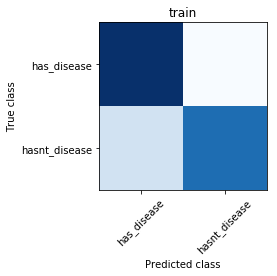

test ################################################################################
Accuracy: 0.7250072653298459
Recall: 0.6671543525969276



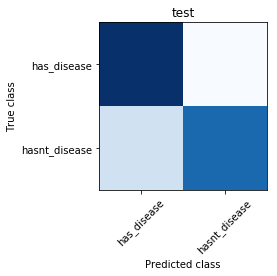

In [14]:
evaluate_model(lr_model, lr_extract_inputs, lr_extract_outputs)

In [15]:
lr_model.steps

[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)),
 ('classifier',
  LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
            intercept_scaling=1, max_iter=100, multi_class='warn',
            n_jobs=None, penalty='l2', random_state=None, solver='warn',
            tol=0.0001, verbose=0, warm_start=False))]

In [16]:
clf = lr_model.steps[1][1]
clf.coef_

array([[ 3.58295494e-01, -7.58072180e-04,  7.58072180e-04,
        -7.97531796e-02,  2.31617134e-01,  8.94852765e-01,
         1.45966650e-01, -1.75413699e-01,  6.84663286e-03,
         2.30991911e-01,  2.95881124e-02,  2.68235274e-02,
        -6.59484996e-02, -4.32451519e-02, -4.81011065e-02,
        -8.10768262e-02, -8.31622747e-02]])

In [17]:
for col_name, weight in zip(LR_INPUT_COLUMNS, clf.coef_[0]):
    print(col_name, ':', weight)

age : 0.3582954942214357
sex_m : -0.0007580721802912454
sex_f : 0.0007580721802908527
height : -0.07975317962270748
weight : 0.2316171342348125
ap_hi : 0.8948527651873259
ap_lo : 0.1459666503384526
cho_lo : -0.1754136985788115
cho_me : 0.0068466328620097085
cho_hi : 0.2309919110487668
gluc_lo : 0.029588112431258563
gluc_me : 0.02682352737309435
gluc_hi : -0.06594849963307613
smoke : -0.04324515186271087
alco : -0.04810110654417746
active : -0.08107682615041943
body_mass : -0.08316227465566177


### Conclusión
En este modelo, utilizando las métricas mencionadas anteriormente, obtuvimos un 72% en Accuracy y un 66% en Recall en la validación.
Aunque el recall no es muy alto, lo vemos aceptable; ya que encontramos más de la mitad de los casos

## Second model: K nearest neighbors

In [18]:
from sklearn.neighbors import KNeighborsClassifier

In [19]:
K = 100

knn_model = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', KNeighborsClassifier(n_neighbors=K)),
])

In [20]:
knn_model.fit(
    lr_extract_inputs(train),
    lr_extract_outputs(train),
)

Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('classifier', KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=100, p=2,
           weights='uniform'))])

train ################################################################################
Accuracy: 0.7327504783124652
Recall: 0.6774383366841563



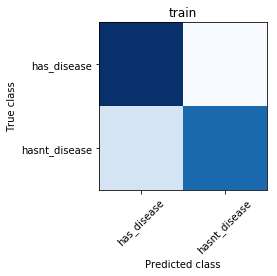

test ################################################################################
Accuracy: 0.724716652136007
Recall: 0.6659839063643014



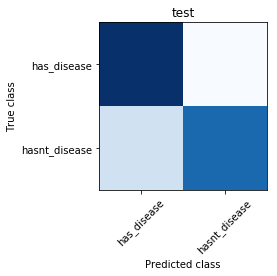

In [21]:
evaluate_model(knn_model, lr_extract_inputs, lr_extract_outputs)

### Conclusión
Al igual que con el modelo anterior, obtuvimos en validación un 72% en Accuracy y un 66% en Recall

Podemos obervar también que los resultados de la validación son casi identicos a los del entrenamiento, lo que nos da indicios de que el modelo se comporta de la misma forma con datos nuevos.

## Third model: Decision Trees


In [24]:
from sklearn.tree import DecisionTreeClassifier

In [25]:
# final input columns, in the order we want to use them
TREE_INPUT_COLUMNS = [
    'age',
    'gender',
    'height',
    'weight',
    'ap_hi',
    'ap_lo',
    'cholesterol',
    'gluc',
    'smoke',
    'alco',
    'active',
    'body_mass'
]


def tree_extract_inputs(dataset):
    """
    Inputs in the format supported by the logistic regressor.
    """
    # we don't want to modify the original dataset, that we will use with other models
    inputs = dataset.copy()
    
    # return the raw numbers
    return inputs[TREE_INPUT_COLUMNS].values

def tree_extract_outputs(dataset):
    """
    Outputs in the format supported by the logistic regressor.
    """
    return dataset.cardio.values

In [26]:
tree_model = DecisionTreeClassifier(max_depth=10)
# max_depth=5?

In [27]:
tree_model.fit(
    tree_extract_inputs(train),
    tree_extract_outputs(train),
)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=10,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

train ################################################################################
Accuracy: 0.7586398973141847
Recall: 0.718972196341882



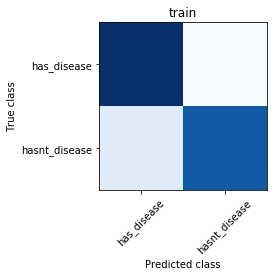

test ################################################################################
Accuracy: 0.723554199360651
Recall: 0.6810534016093636



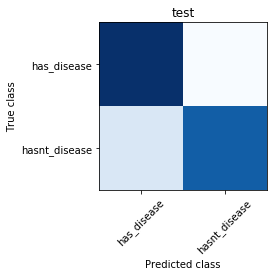

In [28]:
evaluate_model(tree_model, tree_extract_inputs, tree_extract_outputs)

In [29]:
import graphviz  # pip install graphviz
from sklearn.tree import export_graphviz

def graph_tree(tree):
    graph_data = export_graphviz(
        tree, 
        out_file=None, 
        feature_names=TREE_INPUT_COLUMNS,  
        class_names=['has_disease', 'hasnt_disease'],  
        filled=True, 
        rounded=True,  
        special_characters=True,
    )
    graph = graphviz.Source(graph_data)  
    # graph.render('rendered_tree')
    return graph

In [32]:
graph_tree(tree_model)

### Conclusión
En este modelo podemos observar que obtuvimos resultados levemente mejores que con los dos anteriores.
Podemos agrear que son más fáciles de sobrenrenar que la regresión lineal y el K-NN, ya que tuvimos que configurarlo con una profundidad máxima de 10 niveles porque arrojaba resultados por encima del 99% en el train y en el validation solo llegabamos al 60 %

## Fourth model: Random Forests

In [33]:
from sklearn.ensemble import RandomForestClassifier

In [34]:
forest_model = RandomForestClassifier(max_depth=10)
# n_estimators? max_depth=3?, max_features=2?

In [35]:
forest_model.fit(
    tree_extract_inputs(train),
    tree_extract_outputs(train),
)

/home/osboxes/proyectos/tp_ml/env/lib/python3.5/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

train ################################################################################
Accuracy: 0.7573078879174638
Recall: 0.689893590938067



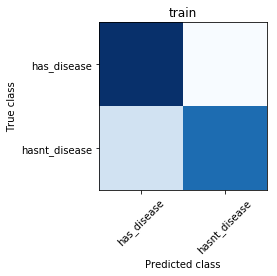

test ################################################################################
Accuracy: 0.7306015693112468
Recall: 0.6664228237015362



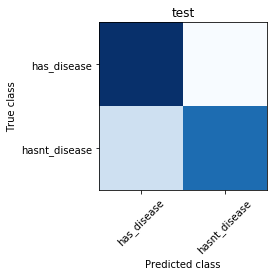

In [36]:
evaluate_model(forest_model, tree_extract_inputs, tree_extract_outputs)

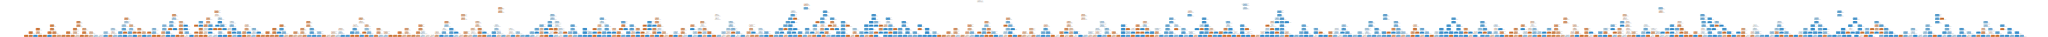

In [261]:
graph_tree(forest_model.estimators_[0])

### Conclusión
Al igual que en el modelo anterior, obtuvimos resultados de Accuracy levemente mejores que con la regresión lineal y el K-NN, pero menor en Recall.
Con resultados del 73% con Accuracy y 66 % con Recall concluimos que este modelo es menos conveniente que los anteriores.


## Fifth model: Gradient Boosted Trees

In [43]:
from sklearn.ensemble import GradientBoostingClassifier

In [44]:
boost_model = GradientBoostingClassifier()

In [45]:
boost_model.fit(
    tree_extract_inputs(train),
    tree_extract_outputs(train),
)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              n_iter_no_change=None, presort='auto', random_state=None,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)

train ################################################################################
Accuracy: 0.7420987624421786
Recall: 0.698573039768548



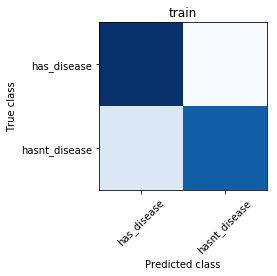

test ################################################################################
Accuracy: 0.7333623946527172
Recall: 0.6893928310168251



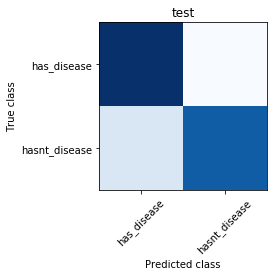

In [59]:
evaluate_model(boost_model, tree_extract_inputs, tree_extract_outputs)

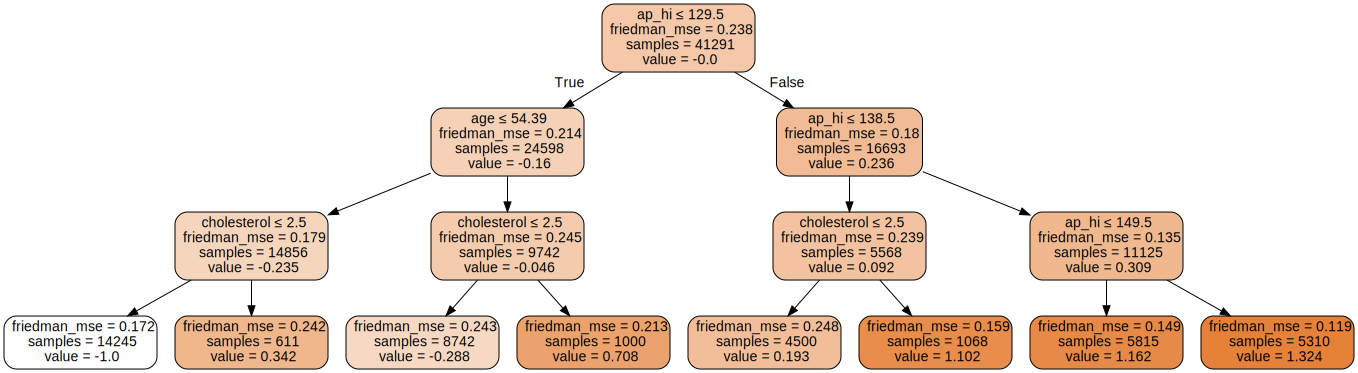

In [199]:
graph_tree(boost_model.estimators_[1][0])

### Conclusión
Hasta ahora los mejores resultados. El accuracy mas alto, junto con Random Forest, y el Recall mas alto, junto con Decision Tree.

Con Accuracy de 73 % y Recall de 68 % concluimos que este modelo es el mas aceptable.

## Sixth model: Neural Networks

In [48]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Input, Dropout

Using TensorFlow backend.


In [49]:
nn_model = Sequential([   
    Dense(50, input_shape=(len(LR_INPUT_COLUMNS), )),
    Activation('tanh'),
    
    Dropout(0.1), 

    Dense(50),
    Activation('tanh'),
    
    Dropout(0.1),

    Dense(1),
    Activation('sigmoid'),
])

nn_model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy',],
)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [50]:
history = nn_model.fit(
    lr_extract_inputs(train), 
    lr_extract_outputs(train),
    epochs=500,
    batch_size=128,
    validation_data=(
        lr_extract_inputs(test),
        lr_extract_outputs(test),
    )
)

Instructions for updating:
Use tf.cast instead.
Train on 41291 samples, validate on 13764 samples
Epoch 1/500
41291/41291 [==============================] - 3s 82us/step - loss: 0.6828 - acc: 0.5757 - val_loss: 0.6539 - val_acc: 0.6130
Epoch 2/500
41291/41291 [==============================] - 1s 32us/step - loss: 0.6623 - acc: 0.6052 - val_loss: 0.6442 - val_acc: 0.6330
Epoch 3/500
41291/41291 [==============================] - 1s 32us/step - loss: 0.6545 - acc: 0.6186 - val_loss: 0.6369 - val_acc: 0.6412
Epoch 4/500
41291/41291 [==============================] - 1s 32us/step - loss: 0.6434 - acc: 0.6370 - val_loss: 0.6298 - val_acc: 0.6540
Epoch 5/500
41291/41291 [==============================] - 1s 32us/step - loss: 0.6354 - acc: 0.6464 - val_loss: 0.6238 - val_acc: 0.6520
Epoch 6/500
41291/41291 [==============================] - 1s 34us/step - loss: 0.6299 - acc: 0.6544 - val_loss: 0.6163 - val_acc: 0.6654
Epoch 7/500
41291/41291 [==============================] - 1s 33us/step - 

41291/41291 [==============================] - 1s 32us/step - loss: 0.5522 - acc: 0.7290 - val_loss: 0.5460 - val_acc: 0.7314
Epoch 58/500
41291/41291 [==============================] - 1s 32us/step - loss: 0.5504 - acc: 0.7293 - val_loss: 0.5485 - val_acc: 0.7268
Epoch 59/500
41291/41291 [==============================] - 1s 32us/step - loss: 0.5511 - acc: 0.7285 - val_loss: 0.5710 - val_acc: 0.7124
Epoch 60/500
41291/41291 [==============================] - 1s 31us/step - loss: 0.5514 - acc: 0.7294 - val_loss: 0.5464 - val_acc: 0.7294
Epoch 61/500
41291/41291 [==============================] - 1s 32us/step - loss: 0.5491 - acc: 0.7310 - val_loss: 0.5489 - val_acc: 0.7306
Epoch 62/500
41291/41291 [==============================] - 1s 31us/step - loss: 0.5516 - acc: 0.7276 - val_loss: 0.5689 - val_acc: 0.7074
Epoch 63/500
41291/41291 [==============================] - 1s 31us/step - loss: 0.5505 - acc: 0.7297 - val_loss: 0.5476 - val_acc: 0.7280
Epoch 64/500
41291/41291 [==============

Epoch 116/500
41291/41291 [==============================] - 1s 30us/step - loss: 0.5493 - acc: 0.7309 - val_loss: 0.5555 - val_acc: 0.7236
Epoch 117/500
41291/41291 [==============================] - 1s 30us/step - loss: 0.5474 - acc: 0.7314 - val_loss: 0.5468 - val_acc: 0.7318
Epoch 118/500
41291/41291 [==============================] - 1s 32us/step - loss: 0.5489 - acc: 0.7304 - val_loss: 0.5490 - val_acc: 0.7288
Epoch 119/500
41291/41291 [==============================] - 1s 31us/step - loss: 0.5491 - acc: 0.7297 - val_loss: 0.5498 - val_acc: 0.7281
Epoch 120/500
41291/41291 [==============================] - 1s 30us/step - loss: 0.5483 - acc: 0.7308 - val_loss: 0.5462 - val_acc: 0.7317
Epoch 121/500
41291/41291 [==============================] - 1s 29us/step - loss: 0.5473 - acc: 0.7300 - val_loss: 0.5637 - val_acc: 0.7156
Epoch 122/500
41291/41291 [==============================] - 1s 32us/step - loss: 0.5484 - acc: 0.7290 - val_loss: 0.5463 - val_acc: 0.7313
Epoch 123/500
41291/

41291/41291 [==============================] - 2s 39us/step - loss: 0.5477 - acc: 0.7289 - val_loss: 0.5467 - val_acc: 0.7290
Epoch 175/500
41291/41291 [==============================] - 2s 40us/step - loss: 0.5472 - acc: 0.7333 - val_loss: 0.5466 - val_acc: 0.7304
Epoch 176/500
41291/41291 [==============================] - 1s 34us/step - loss: 0.5478 - acc: 0.7318 - val_loss: 0.5501 - val_acc: 0.7289
Epoch 177/500
41291/41291 [==============================] - 1s 33us/step - loss: 0.5479 - acc: 0.7309 - val_loss: 0.5518 - val_acc: 0.7213
Epoch 178/500
41291/41291 [==============================] - 1s 33us/step - loss: 0.5481 - acc: 0.7280 - val_loss: 0.5453 - val_acc: 0.7331
Epoch 179/500
41291/41291 [==============================] - 1s 32us/step - loss: 0.5480 - acc: 0.7298 - val_loss: 0.5465 - val_acc: 0.7285
Epoch 180/500
41291/41291 [==============================] - 1s 30us/step - loss: 0.5464 - acc: 0.7305 - val_loss: 0.5462 - val_acc: 0.7316
Epoch 181/500
41291/41291 [=======

41291/41291 [==============================] - 1s 33us/step - loss: 0.5460 - acc: 0.7318 - val_loss: 0.5458 - val_acc: 0.7320
Epoch 233/500
41291/41291 [==============================] - 1s 30us/step - loss: 0.5471 - acc: 0.7309 - val_loss: 0.5459 - val_acc: 0.7323
Epoch 234/500
41291/41291 [==============================] - 1s 30us/step - loss: 0.5463 - acc: 0.7305 - val_loss: 0.5469 - val_acc: 0.7331
Epoch 235/500
41291/41291 [==============================] - 1s 31us/step - loss: 0.5461 - acc: 0.7324 - val_loss: 0.5467 - val_acc: 0.7290
Epoch 236/500
41291/41291 [==============================] - 1s 29us/step - loss: 0.5477 - acc: 0.7302 - val_loss: 0.5477 - val_acc: 0.7315
Epoch 237/500
41291/41291 [==============================] - 1s 34us/step - loss: 0.5483 - acc: 0.7302 - val_loss: 0.5468 - val_acc: 0.7290
Epoch 238/500
41291/41291 [==============================] - 1s 31us/step - loss: 0.5471 - acc: 0.7315 - val_loss: 0.5476 - val_acc: 0.7316
Epoch 239/500
41291/41291 [=======

41291/41291 [==============================] - 1s 31us/step - loss: 0.5463 - acc: 0.7316 - val_loss: 0.5478 - val_acc: 0.7291
Epoch 291/500
41291/41291 [==============================] - 1s 33us/step - loss: 0.5465 - acc: 0.7309 - val_loss: 0.5463 - val_acc: 0.7318
Epoch 292/500
41291/41291 [==============================] - 1s 33us/step - loss: 0.5475 - acc: 0.7307 - val_loss: 0.5468 - val_acc: 0.7307
Epoch 293/500
41291/41291 [==============================] - 1s 33us/step - loss: 0.5477 - acc: 0.7309 - val_loss: 0.5461 - val_acc: 0.7329
Epoch 294/500
41291/41291 [==============================] - 1s 33us/step - loss: 0.5468 - acc: 0.7313 - val_loss: 0.5474 - val_acc: 0.7287
Epoch 295/500
41291/41291 [==============================] - 1s 32us/step - loss: 0.5471 - acc: 0.7297 - val_loss: 0.5527 - val_acc: 0.7230
Epoch 296/500
41291/41291 [==============================] - 1s 31us/step - loss: 0.5460 - acc: 0.7325 - val_loss: 0.5581 - val_acc: 0.7227
Epoch 297/500
41291/41291 [=======

41291/41291 [==============================] - 1s 31us/step - loss: 0.5471 - acc: 0.7317 - val_loss: 0.5512 - val_acc: 0.7313
Epoch 349/500
41291/41291 [==============================] - 1s 30us/step - loss: 0.5466 - acc: 0.7312 - val_loss: 0.5466 - val_acc: 0.7331
Epoch 350/500
41291/41291 [==============================] - 1s 30us/step - loss: 0.5443 - acc: 0.7323 - val_loss: 0.5486 - val_acc: 0.7282
Epoch 351/500
41291/41291 [==============================] - 1s 31us/step - loss: 0.5461 - acc: 0.7326 - val_loss: 0.5447 - val_acc: 0.7293
Epoch 352/500
41291/41291 [==============================] - 1s 32us/step - loss: 0.5450 - acc: 0.7353 - val_loss: 0.5467 - val_acc: 0.7327
Epoch 353/500
41291/41291 [==============================] - 1s 32us/step - loss: 0.5471 - acc: 0.7305 - val_loss: 0.5463 - val_acc: 0.7300
Epoch 354/500
41291/41291 [==============================] - 1s 32us/step - loss: 0.5474 - acc: 0.7299 - val_loss: 0.5526 - val_acc: 0.7308
Epoch 355/500
41291/41291 [=======

41291/41291 [==============================] - 1s 28us/step - loss: 0.5452 - acc: 0.7333 - val_loss: 0.5488 - val_acc: 0.7270
Epoch 407/500
41291/41291 [==============================] - 1s 28us/step - loss: 0.5456 - acc: 0.7310 - val_loss: 0.5455 - val_acc: 0.7306
Epoch 408/500
41291/41291 [==============================] - 1s 29us/step - loss: 0.5461 - acc: 0.7319 - val_loss: 0.5457 - val_acc: 0.7331
Epoch 409/500
41291/41291 [==============================] - 1s 33us/step - loss: 0.5456 - acc: 0.7324 - val_loss: 0.5474 - val_acc: 0.7308
Epoch 410/500
41291/41291 [==============================] - 1s 31us/step - loss: 0.5468 - acc: 0.7305 - val_loss: 0.5467 - val_acc: 0.7298
Epoch 411/500
41291/41291 [==============================] - 1s 30us/step - loss: 0.5460 - acc: 0.7320 - val_loss: 0.5485 - val_acc: 0.7273
Epoch 412/500
41291/41291 [==============================] - 1s 31us/step - loss: 0.5454 - acc: 0.7344 - val_loss: 0.5465 - val_acc: 0.7326
Epoch 413/500
41291/41291 [=======

41291/41291 [==============================] - 1s 30us/step - loss: 0.5451 - acc: 0.7338 - val_loss: 0.5454 - val_acc: 0.7317
Epoch 465/500
41291/41291 [==============================] - 1s 28us/step - loss: 0.5434 - acc: 0.7345 - val_loss: 0.5470 - val_acc: 0.7320
Epoch 466/500
41291/41291 [==============================] - 1s 31us/step - loss: 0.5450 - acc: 0.7322 - val_loss: 0.5481 - val_acc: 0.7283
Epoch 467/500
41291/41291 [==============================] - 1s 29us/step - loss: 0.5455 - acc: 0.7331 - val_loss: 0.5443 - val_acc: 0.7314
Epoch 468/500
41291/41291 [==============================] - 1s 31us/step - loss: 0.5442 - acc: 0.7333 - val_loss: 0.5444 - val_acc: 0.7346
Epoch 469/500
41291/41291 [==============================] - 1s 29us/step - loss: 0.5460 - acc: 0.7317 - val_loss: 0.5461 - val_acc: 0.7308
Epoch 470/500
41291/41291 [==============================] - 1s 30us/step - loss: 0.5445 - acc: 0.7322 - val_loss: 0.5473 - val_acc: 0.7289
Epoch 471/500
41291/41291 [=======

train ################################################################################
Accuracy: 0.7327504783124652
Recall: 0.6774383366841563



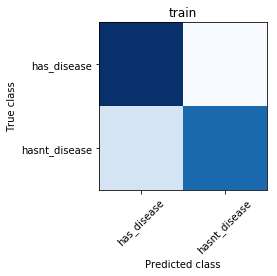

test ################################################################################
Accuracy: 0.724716652136007
Recall: 0.6659839063643014



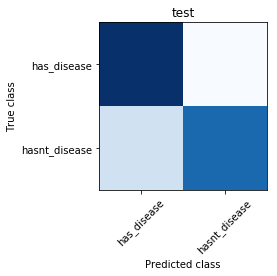

validation ################################################################################
Accuracy: 0.7237721592560302
Recall: 0.6602226127709432



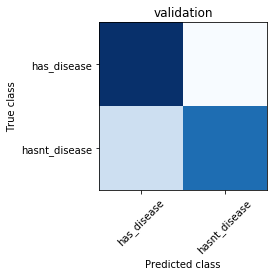

In [52]:
evaluate_model(knn_model, lr_extract_inputs, lr_extract_outputs, True)

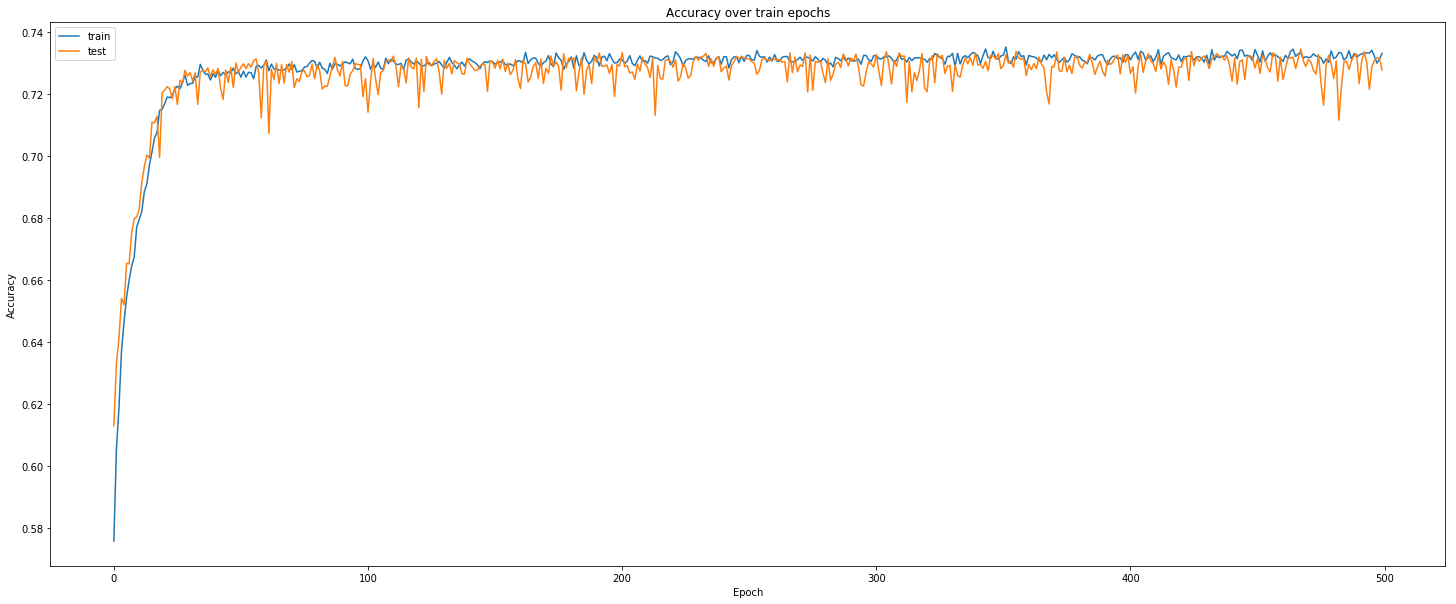

In [53]:
# plot accuracy over training epochs
plt.plot(history.history['acc'], label='train')
plt.plot(history.history['val_acc'], label='test')
plt.title('Accuracy over train epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

### Conclusión
Luego de varias iteraciones sobre diferentes modelos de NN, no logramos mejorar los resultados obtenidos a traves de otros modelos, en ninguno de los 3 sets de datos.
Probablemente se pueda mejorar un poco los resultados con las funciones de activacion y las cantidades de neuronas por capa correctas, pero teniendo en cuenta que los resultados de todos los modelos no llegan siquiera a un 75% de Accuracy, sospechamos que puede deberse al dataset utilizado, cuyos datos no provean suficiente informacion para lograr mejores predicciones.

## Conclusión final
El mejor resultado obtenido fue mediante Gradient Boosted Tree:

train ################################################################################
Accuracy: 0.7420987624421786
Recall: 0.698573039768548



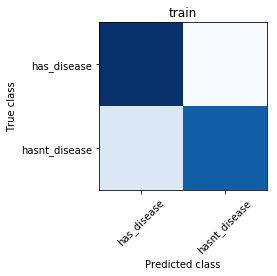

test ################################################################################
Accuracy: 0.7333623946527172
Recall: 0.6893928310168251



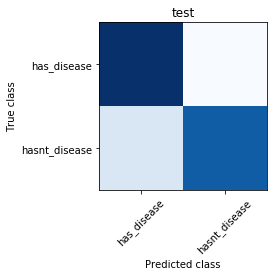

validation ################################################################################
Accuracy: 0.7257337983144435
Recall: 0.6788224956063269



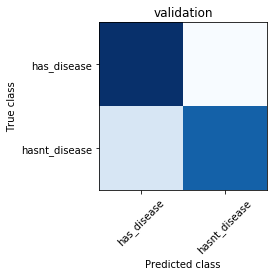

In [70]:
evaluate_model(boost_model, tree_extract_inputs, tree_extract_outputs, True) #con validation

Como podemos ver en la validacion:

Accuracy: 0.7257337983144435

Recall: 0.6788224956063269

No es el mejor resultado de Accuracy obtenido, pero con casi un 68% de Recall es la mejor combinacion de estas metricas que pudimos obtener en comparacion con las validaciones del resto de los modelos.

No nos parece un resultado destacable, pero en base a que los resultados entre modelos no presentan mucha variacion, puede deberse a que el dataset no provea suficiente informacion para lograr mejores predicciones.

Podemos decir que este modelo predecira correctamente el 72% de las veces.
